In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Flatten, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Activation, Multiply
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import Sequence

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
from tensorflow.keras.layers import Layer, Dense, Activation, Multiply, Lambda
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(name='att_var', 
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, timesteps, features)
        # Score calculation for each time step
        score = K.tanh(K.dot(inputs, self.W) + self.b)  # (batch_size, timesteps, features)
        score = K.dot(score, self.V)  # (batch_size, timesteps, 1)
        attention_weights = K.softmax(score, axis=1)  # (batch_size, timesteps, 1)
        
        # Multiply each time step by its attention weight
        context_vector = inputs * attention_weights  # (batch_size, timesteps, features)
        context_vector = K.sum(context_vector, axis=1)   # (batch_size, features)
        return context_vector

# Convenience function to use the layer
def attention_layer(inputs):
    return AttentionLayer()(inputs)


In [5]:
def build_model(input_shape=(299, 299, 9)):
    """
    Builds an improved Xception-based spatial feature extractor and a Bidirectional LSTM
    for temporal analysis with pooling layers and batch normalization.
    """
    print("Building improved model...")

    # Spatial Feature Extractor
    base_model = Xception(include_top=False, weights=None, input_shape=input_shape)

    # Use GlobalAveragePooling2D to aggregate the spatial features.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    spatial_model = Model(inputs=base_model.input, outputs=x, name="spatial_model")

    # Temporal Analysis with LSTM (Improved)
    lstm_input = Input(shape=(None, 512), name="lstm_input")

    # First LSTM remains the same:
    lstm_out = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.2))(lstm_input)
    # Change the second LSTM to output sequences (i.e., 3D tensor)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.4))(lstm_out)

    # Now attention_layer receives a 3D tensor as expected
    attn_out = attention_layer(lstm_out)
    attn_out = BatchNormalization()(attn_out)

    output = Dense(1, activation='sigmoid')(attn_out)
    temporal_model = Model(inputs=lstm_input, outputs=output, name="temporal_model")

    print("Improved model built successfully.")
    return spatial_model, temporal_model


def train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32):
    """Trains the model with improved training strategy."""
    print("Extracting features from Xception (Spatial Model)...")

    # Extract features from Xception
    x_train_features = spatial_model.predict(x_train)
    x_test_features = spatial_model.predict(x_test)

    # Reshape for LSTM
    x_train_features = np.expand_dims(x_train_features, axis=1)
    x_test_features = np.expand_dims(x_test_features, axis=1)

    # Compile the LSTM (Temporal Model)
    temporal_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    print("Training Improved Temporal Model (LSTM)...")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        filepath="best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        verbose=1
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

    # Train the LSTM Model
    history = temporal_model.fit(
        x_train_features, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_features, y_test),
        callbacks=[model_checkpoint, early_stopping, lr_reducer]
    )

    print("Training completed.")

    # Predict on test set
    y_pred = temporal_model.predict(x_test_features)

    # Evaluate model
    plot_metrics(history, y_test, y_pred)


def plot_metrics(history, y_test, y_pred):
    """Plots training metrics, evaluation metrics, ROC curve, and precision-recall curve."""
    # Training Loss and Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Compute Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Print evaluation metrics
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_binary):.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f'Recall Score: {recall_score(y_test, y_pred_binary):.4f}')
    print(f'Precision Score: {precision_score(y_test, y_pred_binary):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred_binary):.4f}')
    print(f'PR AUC Score: {pr_auc:.4f}')
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))

In [6]:
# # Load precomputed dataset
# save_path = "E:/dataset_1/preprocessed_happy.npz"
# print(f"📂 Loading precomputed dataset from {save_path}...")
# data = np.load(save_path)

# # Extract x_data and y_data
# x_data, y_data = data["x"], data["y"]
# print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# # Train-test split
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# # Verify shapes
# print(f"📊 Train/Test Split:")
# print(f"  x_train: {x_train.shape}, y_train: {y_train.shape}")
# print(f"  x_test: {x_test.shape}, y_test: {y_test.shape}")

In [7]:



# Create a Sequence wrapper to load batches from the memmap on demand.
class MemmapSequence(Sequence):
    def __init__(self, memmap_array, indices, batch_size=32):
        self.memmap_array = memmap_array
        self.indices = indices
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        # When using fancy indexing on a memmap, a copy is made only for this batch.
        return self.memmap_array[batch_idx]

# --- Data Loading Without Loading Entire Dataset Into RAM ---

# Load the dataset with memory mapping so that the full array isn’t loaded into RAM immediately.
save_path = "E:/dataset_1/preprocessed_contempt.npz"
print(f"📂 Loading precomputed dataset from {save_path}...")
data = np.load(save_path, mmap_mode='r')  # memmap; data remains on disk until accessed
x_data, y_data = data["x"], data["y"]
print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# Use StratifiedShuffleSplit to get train/test indices without forcing a full copy.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(x_data, y_data))

# Sorting indices can help get more contiguous slices.
train_idx = np.sort(train_idx)
test_idx = np.sort(test_idx)

# Instead of slicing x_data (which would copy a 12GB block into memory),
# create Sequences that load data in batches.
batch_size = 32
x_train_seq = MemmapSequence(x_data, train_idx, batch_size=batch_size)
x_test_seq = MemmapSequence(x_data, test_idx, batch_size=batch_size)

# y_data is small so we load it normally.
y_train = y_data[train_idx]
y_test = y_data[test_idx]

print("📊 Train/Test Split:")
print(f"  x_train_seq: {len(x_train_seq)} batches (batch_size={batch_size}), y_train: {y_train.shape}")
print(f"  x_test_seq: {len(x_test_seq)} batches (batch_size={batch_size}), y_test: {y_test.shape}")

# --- Training the Model ---
# Now call your train_model function as before—but pass the Sequence objects instead of full numpy arrays.
# For example:
#
# spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))
# train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test)
#
# Keras model.predict (and model.fit, if needed) supports Sequence objects, so your existing
# build_model() and train_model() functions remain unchanged.


📂 Loading precomputed dataset from E:/dataset_1/preprocessed_contempt.npz...
✅ Loaded dataset: 19999 samples.
📊 Train/Test Split:
  x_train_seq: 500 batches (batch_size=32), y_train: (15999,)
  x_test_seq: 125 batches (batch_size=32), y_test: (4000,)


In [8]:
# if __name__ == "__main__":
#     real_faces = "E:/Research/real/Cropped_Faces"
#     fake_faces = "E:/Research/fake/Cropped_Faces"
    # real_data, fake_data = prepare_data(real_faces, "", fake_faces, "")
    
    # Build the Spatial and Temporal Models
spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test = y_test.astype('float32')

# spatial_model.summary()
temporal_model.summary()


Building improved model...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\applications\xception.py:111: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  input_shape = imagenet_utils.obtain_input_shape(



Improved model built successfully.


Model: "temporal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 256)      │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 256)            │        66,048 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,298,625 (8.77 MB)

 Trainable params: 2,298,113 (8.77 MB)

 Non-trainable params: 512 (2.00 KB)

Extracting features from Xception (Spatial Model)...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 1858s 4s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 486s 4s/step
Training Improved Temporal Model (LSTM)...
Epoch 1/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5069 - loss: 0.6931
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.5070 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930 - learning_rate: 1.0000e-04
Epoch 2/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5404 - loss: 0.6923
Epoch 2: val_accuracy improved from 0.50000 to 0.59400, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5405 - loss: 0.6923 - val_accuracy: 0.5940 - val_loss: 0.6894 - learning_rate: 1.0000e-04
Epoch 3/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6206 - loss: 0.6868
Epoch 3: val_accuracy did not improve from 0.59400
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6207 - loss: 0.6868 - val_accuracy: 0.5000 - val_loss: 0.6740 - learning_rate: 1.0000e-04
Epoch 4/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6812 - loss: 0.6633
Epoch 4: val_accuracy did not improve from 0.59400
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6813 - loss: 0.6632 - val_accuracy: 0.5000 - val_loss: 0.6792 - learning_rate: 1.0000e-04
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7746 - loss: 0.5709
Epoch 5: val_accuracy did not improve from 0.59400
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7747 - loss: 0.5708 - val_accuracy: 0.5000 - val_loss: 0.7299 - learning_rate: 1.0000

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8290 - loss: 0.4405 - val_accuracy: 0.7078 - val_loss: 0.5234 - learning_rate: 1.0000e-04
Epoch 7/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8371 - loss: 0.3738
Epoch 7: val_accuracy improved from 0.70775 to 0.78700, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8372 - loss: 0.3738 - val_accuracy: 0.7870 - val_loss: 0.4217 - learning_rate: 1.0000e-04
Epoch 8/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8518 - loss: 0.3440
Epoch 8: val_accuracy improved from 0.78700 to 0.85575, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8518 - loss: 0.3439 - val_accuracy: 0.8558 - val_loss: 0.3261 - learning_rate: 1.0000e-04
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8563 - loss: 0.3338
Epoch 9: val_accuracy did not improve from 0.85575
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8563 - loss: 0.3338 - val_accuracy: 0.8490 - val_loss: 0.3271 - learning_rate: 1.0000e-04
Epoch 10/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8578 - loss: 0.3268
Epoch 10: val_accuracy improved from 0.85575 to 0.85800, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8578 - loss: 0.3268 - val_accuracy: 0.8580 - val_loss: 0.3123 - learning_rate: 1.0000e-04
Epoch 11/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8569 - loss: 0.3317
Epoch 11: val_accuracy improved from 0.85800 to 0.86925, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8569 - loss: 0.3316 - val_accuracy: 0.8692 - val_loss: 0.2985 - learning_rate: 1.0000e-04
Epoch 12/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8631 - loss: 0.3175
Epoch 12: val_accuracy improved from 0.86925 to 0.88050, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8631 - loss: 0.3175 - val_accuracy: 0.8805 - val_loss: 0.2839 - learning_rate: 1.0000e-04
Epoch 13/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8669 - loss: 0.3136
Epoch 13: val_accuracy did not improve from 0.88050
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8669 - loss: 0.3136 - val_accuracy: 0.8773 - val_loss: 0.2842 - learning_rate: 1.0000e-04
Epoch 14/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8706 - loss: 0.3100
Epoch 14: val_accuracy did not improve from 0.88050
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8706 - loss: 0.3100 - val_accuracy: 0.8735 - val_loss: 0.2883 - learning_rate: 1.0000e-04
Epoch 15/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8691 - loss: 0.3086
Epoch 15: val_accuracy did not improve from 0.88050
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8691 - loss: 0.3086 - val_accuracy: 0.8770 - val_loss: 0.2805 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8772 - loss: 0.2998 - val_accuracy: 0.8830 - val_loss: 0.2686 - learning_rate: 1.0000e-04
Epoch 18/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8704 - loss: 0.3057
Epoch 18: val_accuracy did not improve from 0.88300
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8704 - loss: 0.3057 - val_accuracy: 0.8692 - val_loss: 0.2920 - learning_rate: 1.0000e-04
Epoch 19/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8813 - loss: 0.2911
Epoch 19: val_accuracy improved from 0.88300 to 0.88900, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8813 - loss: 0.2910 - val_accuracy: 0.8890 - val_loss: 0.2569 - learning_rate: 1.0000e-04
Epoch 20/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8804 - loss: 0.2844
Epoch 20: val_accuracy did not improve from 0.88900
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8804 - loss: 0.2844 - val_accuracy: 0.8880 - val_loss: 0.2593 - learning_rate: 1.0000e-04
Epoch 21/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8866 - loss: 0.2843
Epoch 21: val_accuracy improved from 0.88900 to 0.89875, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8866 - loss: 0.2843 - val_accuracy: 0.8988 - val_loss: 0.2428 - learning_rate: 1.0000e-04
Epoch 22/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8854 - loss: 0.2720
Epoch 22: val_accuracy improved from 0.89875 to 0.90075, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8854 - loss: 0.2720 - val_accuracy: 0.9007 - val_loss: 0.2396 - learning_rate: 1.0000e-04
Epoch 23/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8868 - loss: 0.2750
Epoch 23: val_accuracy improved from 0.90075 to 0.90600, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8868 - loss: 0.2750 - val_accuracy: 0.9060 - val_loss: 0.2336 - learning_rate: 1.0000e-04
Epoch 24/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8912 - loss: 0.2656
Epoch 24: val_accuracy improved from 0.90600 to 0.90950, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8912 - loss: 0.2656 - val_accuracy: 0.9095 - val_loss: 0.2259 - learning_rate: 1.0000e-04
Epoch 25/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8917 - loss: 0.2694
Epoch 25: val_accuracy did not improve from 0.90950
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8917 - loss: 0.2694 - val_accuracy: 0.8890 - val_loss: 0.2537 - learning_rate: 1.0000e-04
Epoch 26/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8977 - loss: 0.2527
Epoch 26: val_accuracy improved from 0.90950 to 0.91325, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8977 - loss: 0.2527 - val_accuracy: 0.9133 - val_loss: 0.2155 - learning_rate: 1.0000e-04
Epoch 27/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8977 - loss: 0.2545
Epoch 27: val_accuracy improved from 0.91325 to 0.91400, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8977 - loss: 0.2545 - val_accuracy: 0.9140 - val_loss: 0.2148 - learning_rate: 1.0000e-04
Epoch 28/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8958 - loss: 0.2535
Epoch 28: val_accuracy did not improve from 0.91400
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8958 - loss: 0.2534 - val_accuracy: 0.8770 - val_loss: 0.2731 - learning_rate: 1.0000e-04
Epoch 29/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9003 - loss: 0.2467
Epoch 29: val_accuracy improved from 0.91400 to 0.92300, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9003 - loss: 0.2467 - val_accuracy: 0.9230 - val_loss: 0.2005 - learning_rate: 1.0000e-04
Epoch 30/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9059 - loss: 0.2367
Epoch 30: val_accuracy did not improve from 0.92300
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9058 - loss: 0.2368 - val_accuracy: 0.9155 - val_loss: 0.2109 - learning_rate: 1.0000e-04
Epoch 31/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9005 - loss: 0.2474
Epoch 31: val_accuracy did not improve from 0.92300
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9005 - loss: 0.2474 - val_accuracy: 0.9168 - val_loss: 0.2089 - learning_rate: 1.0000e-04
Epoch 32/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9086 - loss: 0.2330
Epoch 32: val_accuracy improved from 0.92300 to 0.92975, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9086 - loss: 0.2330 - val_accuracy: 0.9298 - val_loss: 0.1852 - learning_rate: 1.0000e-04
Epoch 33/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9080 - loss: 0.2296
Epoch 33: val_accuracy did not improve from 0.92975
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9080 - loss: 0.2296 - val_accuracy: 0.9128 - val_loss: 0.2118 - learning_rate: 1.0000e-04
Epoch 34/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9115 - loss: 0.2215
Epoch 34: val_accuracy improved from 0.92975 to 0.93150, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9115 - loss: 0.2215 - val_accuracy: 0.9315 - val_loss: 0.1824 - learning_rate: 1.0000e-04
Epoch 35/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9119 - loss: 0.2191
Epoch 35: val_accuracy improved from 0.93150 to 0.94050, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9119 - loss: 0.2191 - val_accuracy: 0.9405 - val_loss: 0.1699 - learning_rate: 1.0000e-04
Epoch 36/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9111 - loss: 0.2299
Epoch 36: val_accuracy improved from 0.94050 to 0.94375, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9111 - loss: 0.2298 - val_accuracy: 0.9438 - val_loss: 0.1647 - learning_rate: 1.0000e-04
Epoch 37/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9119 - loss: 0.2160
Epoch 37: val_accuracy did not improve from 0.94375
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9119 - loss: 0.2160 - val_accuracy: 0.9247 - val_loss: 0.1853 - learning_rate: 1.0000e-04
Epoch 38/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9192 - loss: 0.2058
Epoch 38: val_accuracy did not improve from 0.94375
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9192 - loss: 0.2058 - val_accuracy: 0.9405 - val_loss: 0.1648 - learning_rate: 1.0000e-04
Epoch 39/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9188 - loss: 0.2047
Epoch 39: val_accuracy improved from 0.94375 to 0.94950, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9188 - loss: 0.2047 - val_accuracy: 0.9495 - val_loss: 0.1506 - learning_rate: 1.0000e-04
Epoch 40/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9222 - loss: 0.2056
Epoch 40: val_accuracy did not improve from 0.94950
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9222 - loss: 0.2055 - val_accuracy: 0.9482 - val_loss: 0.1503 - learning_rate: 1.0000e-04
Epoch 41/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9288 - loss: 0.1958
Epoch 41: val_accuracy did not improve from 0.94950
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9288 - loss: 0.1958 - val_accuracy: 0.9325 - val_loss: 0.1676 - learning_rate: 1.0000e-04
Epoch 42/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9182 - loss: 0.2029
Epoch 42: val_accuracy improved from 0.94950 to 0.95200, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9183 - loss: 0.2029 - val_accuracy: 0.9520 - val_loss: 0.1409 - learning_rate: 1.0000e-04
Epoch 43/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9271 - loss: 0.1882
Epoch 43: val_accuracy did not improve from 0.95200
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9271 - loss: 0.1883 - val_accuracy: 0.9408 - val_loss: 0.1572 - learning_rate: 1.0000e-04
Epoch 44/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9263 - loss: 0.1984
Epoch 44: val_accuracy improved from 0.95200 to 0.95800, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9263 - loss: 0.1984 - val_accuracy: 0.9580 - val_loss: 0.1325 - learning_rate: 1.0000e-04
Epoch 45/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9312 - loss: 0.1840
Epoch 45: val_accuracy did not improve from 0.95800
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9312 - loss: 0.1840 - val_accuracy: 0.9107 - val_loss: 0.2104 - learning_rate: 1.0000e-04
Epoch 46/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9265 - loss: 0.2016
Epoch 46: val_accuracy did not improve from 0.95800
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9266 - loss: 0.2016 - val_accuracy: 0.9455 - val_loss: 0.1498 - learning_rate: 1.0000e-04
Epoch 47/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9266 - loss: 0.1905
Epoch 47: val_accuracy did not improve from 0.95800
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9267 - loss: 0.1905 - val_accuracy: 0.9273 - val_loss: 0.1902 - learning_rate: 1.

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9363 - loss: 0.1693 - val_accuracy: 0.9597 - val_loss: 0.1216 - learning_rate: 5.0000e-05
Epoch 51/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9301 - loss: 0.1781
Epoch 51: val_accuracy improved from 0.95975 to 0.96050, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9301 - loss: 0.1781 - val_accuracy: 0.9605 - val_loss: 0.1204 - learning_rate: 5.0000e-05
Epoch 52/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9355 - loss: 0.1703
Epoch 52: val_accuracy improved from 0.96050 to 0.96100, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9355 - loss: 0.1703 - val_accuracy: 0.9610 - val_loss: 0.1173 - learning_rate: 5.0000e-05
Epoch 53/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9411 - loss: 0.1615
Epoch 53: val_accuracy did not improve from 0.96100
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9411 - loss: 0.1615 - val_accuracy: 0.9595 - val_loss: 0.1190 - learning_rate: 5.0000e-05
Epoch 54/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9393 - loss: 0.1645
Epoch 54: val_accuracy improved from 0.96100 to 0.96275, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9393 - loss: 0.1645 - val_accuracy: 0.9628 - val_loss: 0.1147 - learning_rate: 5.0000e-05
Epoch 55/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9354 - loss: 0.1719
Epoch 55: val_accuracy did not improve from 0.96275
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9354 - loss: 0.1719 - val_accuracy: 0.9565 - val_loss: 0.1243 - learning_rate: 5.0000e-05
Epoch 56/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9361 - loss: 0.1719
Epoch 56: val_accuracy did not improve from 0.96275
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9361 - loss: 0.1719 - val_accuracy: 0.9615 - val_loss: 0.1131 - learning_rate: 5.0000e-05
Epoch 57/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9378 - loss: 0.1732
Epoch 57: val_accuracy did not improve from 0.96275
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9378 - loss: 0.1732 - val_accuracy: 0.9622 - val_loss: 0.1115 - learning_rate: 5.00

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9380 - loss: 0.1674 - val_accuracy: 0.9630 - val_loss: 0.1108 - learning_rate: 5.0000e-05
Epoch 60/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9412 - loss: 0.1633
Epoch 60: val_accuracy did not improve from 0.96300
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9412 - loss: 0.1633 - val_accuracy: 0.9630 - val_loss: 0.1089 - learning_rate: 5.0000e-05
Epoch 61/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9380 - loss: 0.1658
Epoch 61: val_accuracy did not improve from 0.96300
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9380 - loss: 0.1658 - val_accuracy: 0.9620 - val_loss: 0.1115 - learning_rate: 5.0000e-05
Epoch 62/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9444 - loss: 0.1539
Epoch 62: val_accuracy improved from 0.96300 to 0.96375, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9444 - loss: 0.1539 - val_accuracy: 0.9638 - val_loss: 0.1085 - learning_rate: 5.0000e-05
Epoch 63/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9421 - loss: 0.1622
Epoch 63: val_accuracy did not improve from 0.96375
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9421 - loss: 0.1622 - val_accuracy: 0.9605 - val_loss: 0.1222 - learning_rate: 5.0000e-05
Epoch 64/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9387 - loss: 0.1764
Epoch 64: val_accuracy did not improve from 0.96375
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9387 - loss: 0.1763 - val_accuracy: 0.9510 - val_loss: 0.1300 - learning_rate: 5.0000e-05
Epoch 65/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9403 - loss: 0.1614
Epoch 65: val_accuracy did not improve from 0.96375
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9403 - loss: 0.1614 - val_accuracy: 0.9600 - val_loss: 0.1173 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9419 - loss: 0.1646 - val_accuracy: 0.9647 - val_loss: 0.1046 - learning_rate: 2.5000e-05
Epoch 68/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9405 - loss: 0.1586
Epoch 68: val_accuracy did not improve from 0.96475
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9405 - loss: 0.1587 - val_accuracy: 0.9595 - val_loss: 0.1144 - learning_rate: 2.5000e-05
Epoch 69/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9434 - loss: 0.1560
Epoch 69: val_accuracy did not improve from 0.96475
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9434 - loss: 0.1560 - val_accuracy: 0.9645 - val_loss: 0.1041 - learning_rate: 2.5000e-05
Epoch 70/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9427 - loss: 0.1564
Epoch 70: val_accuracy did not improve from 0.96475
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9427 - loss: 0.1564 - val_accuracy: 0.9630 - val_loss: 0.1070 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9390 - loss: 0.1638 - val_accuracy: 0.9650 - val_loss: 0.1029 - learning_rate: 2.5000e-05
Epoch 74/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9439 - loss: 0.1566
Epoch 74: val_accuracy improved from 0.96500 to 0.96525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9439 - loss: 0.1567 - val_accuracy: 0.9653 - val_loss: 0.1027 - learning_rate: 2.5000e-05
Epoch 75/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9437 - loss: 0.1542
Epoch 75: val_accuracy improved from 0.96525 to 0.96550, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9437 - loss: 0.1542 - val_accuracy: 0.9655 - val_loss: 0.1027 - learning_rate: 2.5000e-05
Epoch 76/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9427 - loss: 0.1536
Epoch 76: val_accuracy did not improve from 0.96550
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9427 - loss: 0.1535 - val_accuracy: 0.9647 - val_loss: 0.1036 - learning_rate: 2.5000e-05
Epoch 77/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9383 - loss: 0.1660
Epoch 77: val_accuracy did not improve from 0.96550
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9383 - loss: 0.1660 - val_accuracy: 0.9645 - val_loss: 0.1031 - learning_rate: 2.5000e-05
Epoch 78/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9422 - loss: 0.1589
Epoch 78: val_accuracy improved from 0.96550 to 0.96675, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9422 - loss: 0.1589 - val_accuracy: 0.9668 - val_loss: 0.1014 - learning_rate: 2.5000e-05
Epoch 79/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9390 - loss: 0.1569
Epoch 79: val_accuracy did not improve from 0.96675
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9390 - loss: 0.1569 - val_accuracy: 0.9660 - val_loss: 0.1014 - learning_rate: 2.5000e-05
Epoch 80/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9397 - loss: 0.1659
Epoch 80: val_accuracy did not improve from 0.96675
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9397 - loss: 0.1659 - val_accuracy: 0.9657 - val_loss: 0.1016 - learning_rate: 2.5000e-05
Epoch 81/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9396 - loss: 0.1639
Epoch 81: val_accuracy did not improve from 0.96675
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9396 - loss: 0.1638 - val_accuracy: 0.9665 - val_loss: 0.1010 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9448 - loss: 0.1512 - val_accuracy: 0.9670 - val_loss: 0.1004 - learning_rate: 2.5000e-05
Epoch 84/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9445 - loss: 0.1589
Epoch 84: val_accuracy did not improve from 0.96700
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9445 - loss: 0.1588 - val_accuracy: 0.9628 - val_loss: 0.1073 - learning_rate: 2.5000e-05
Epoch 85/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9402 - loss: 0.1659
Epoch 85: val_accuracy did not improve from 0.96700
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9402 - loss: 0.1659 - val_accuracy: 0.9647 - val_loss: 0.1014 - learning_rate: 2.5000e-05
Epoch 86/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9470 - loss: 0.1514
Epoch 86: val_accuracy did not improve from 0.96700
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9470 - loss: 0.1514 - val_accuracy: 0.9660 - val_loss: 0.0995 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9443 - loss: 0.1527 - val_accuracy: 0.9672 - val_loss: 0.0983 - learning_rate: 1.2500e-05
Epoch 93/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9423 - loss: 0.1574
Epoch 93: val_accuracy did not improve from 0.96725
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9424 - loss: 0.1574 - val_accuracy: 0.9668 - val_loss: 0.0984 - learning_rate: 1.2500e-05
Epoch 94/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9422 - loss: 0.1554
Epoch 94: val_accuracy did not improve from 0.96725
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9422 - loss: 0.1554 - val_accuracy: 0.9663 - val_loss: 0.0980 - learning_rate: 1.2500e-05
Epoch 95/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9467 - loss: 0.1529
Epoch 95: val_accuracy did not improve from 0.96725
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9467 - loss: 0.1529 - val_accuracy: 0.9670 - val_loss: 0.0982 - learning_rate: 

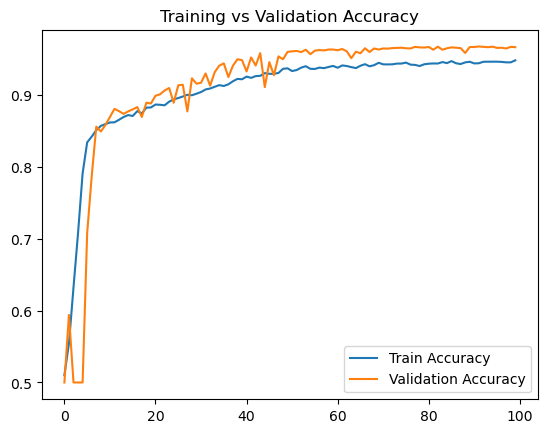

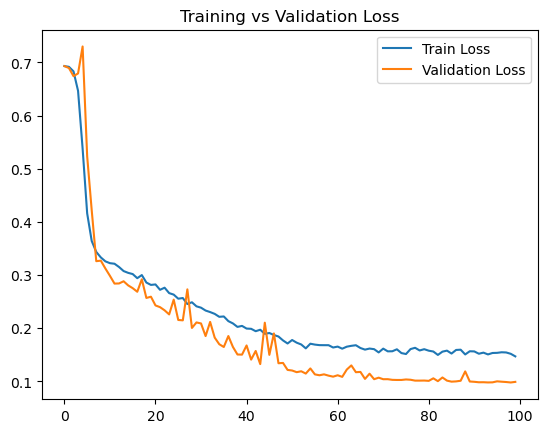

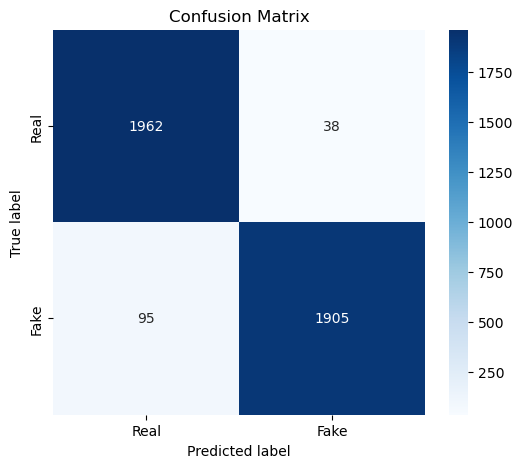

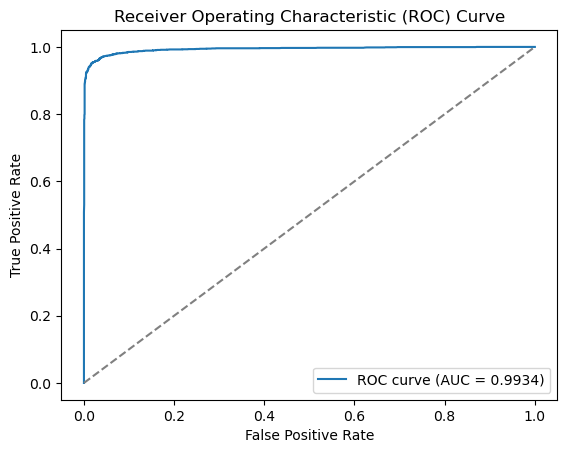

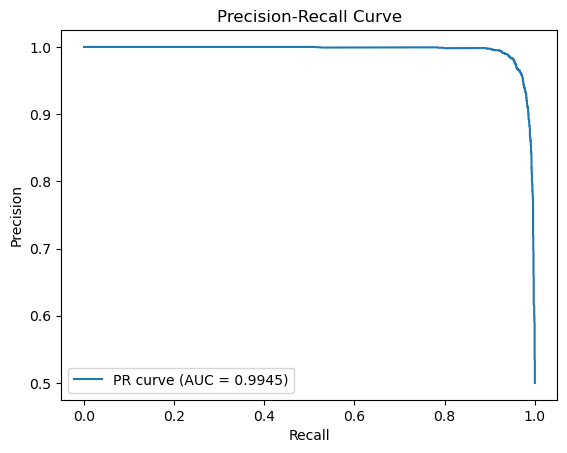

Accuracy Score: 0.9667
ROC AUC Score: 0.9934
Recall Score: 0.9525
Precision Score: 0.9804
F1 Score: 0.9663
PR AUC Score: 0.9945
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2000
           1       0.98      0.95      0.97      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



In [9]:
# Train the Model
train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test, epochs=100, batch_size=32)